# Using keithley as the load (instead of kepco)

In [1]:
import numpy as np
import matplotlib as plt
import os
import serial
import time
import h5py
import sys
%matplotlib notebook

import matplotlib.pyplot as plt
from frghardware.components.FLIR import FLIR
from frghardware.components.opfo import opfo
# from frghardware.components.kepco import Kepco
from frghardware.components.daqPL3 import PLDAQ3
from frghardware.components.laser import Laser808
from frghardware.components.tec import omega
from frghardware.keithleyjv import control3

import datetime
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
import pdb
import winsound
from frgpl.checkPLmaps import plotPL

# soundpath='C:\\Users\\Operator\\Documents\\GitHub\\Instruments\\FRG Hardware\\frgpl\\frgpl\\tada.wav'

today = datetime.datetime.now() # create a folder in Data that's today's date
path =  f"x{today.strftime('%Y%m%d')}" 
root = f"F:\\{path}"

if not os.path.exists(root):
    os.mkdir(root)
datafolder = os.path.join(root, 'Data')
if not os.path.exists(datafolder):
    os.mkdir(datafolder)
calibrationfolder = os.path.join(root, 'Calibration')
if not os.path.exists(calibrationfolder):
    os.mkdir(calibrationfolder)


class Control:

    def __init__(self, tecport = 'COM6', kepcoport = 'COM4',laserport = 'COM7', spotmapnumber = None):
        # hardware properties
#         self.kepcoport = kepcoport
        self.laserport = laserport
        self.tecport = tecport
        self.__laserON = False
#         self.__kepcoON = False
        self.__keithleyON = False
        self.__cameraON = False

        # measurement settings
        self.bias = 0			#bias applied to sample
        self.laserpower = 0	#current supplied to laser ###may replace this with n_suns, if calibration is enabled
        self.vocmode = True # ZJD added 2024/05/26
        self.saturationtime = 0.5	#delay between applying voltage/illumination and beginning measurement
        self.numIV = 20		#number of IV measurements to average
        self.numframes = 20	#number of image frames to average
        self.__temperature = 25	#TEC stage temperature setpoint (C) during measurement
        self.temperatureTolerance = 0.2	#how close to the setpoint we need to be to take a measurement (C)
        self.maxSoakTime = 60	# max soak time, in seconds, to wait for temperature to reach set point. If we reach this point, just go ahead with the measurement
        self.note = ''
        self._spotMap = None	# optical power map of laser spot, used for PL normalization
        self._sampleOneSun = None # fractional laser power with which to approximate one-sun injection levels
        self._sampleOneSunJsc = None # target Jsc, matching of which is used for one-sun injection level is approximated
        self._sampleOneSunSweep = None # fractional laser power vs photocurrent (Isc), fit to provide one-sun estimate
        self.__previewFigure = None	#handle for matplotlib figure, used for previewing most recent image results
        self.__previewAxes = [None, None]	# handle for matplotib axes, used to hold the image and colorbar
        self.__backgroundImage = None

        # data saving settings
        todaysDate = datetime.datetime.now().strftime('%Y%m%d')
        self.outputDirectory = os.path.join(root, 'Data', todaysDate)	#default save locations is desktop/frgPL/Data/(todaysDate)
        self.sampleName = None
        self.__dataBuffer = [] # buffer to hold data files during sequential measurements of single sample. Held until a batch export

        # stage/positioning constants
        self.__sampleposition = (109, 30.25)	#position where TEC stage is centered in camera FOV, um
        self.__detectorposition = (125, 89.5)	#delta position between detector and sampleposition, um.
        self.__fov = (64, 51.2)	#dimensions of FOV, um

        self.connect()
#         self.loadSpotCalibration(spotmapnumber)
    @property
    def temperature(self):
        return self.__temperature

    @temperature.setter
    def temperature(self, t):
        self.tec.setpoint = t
        self.__temperature = t



    def connect(self):
        self.camera = FLIR()		# connect to FLIR camera
#         self.kepco = Kepco(self.kepcoport)		# connect to Kepco
#         self.kepco.set(voltage=0)   # set voltage to 0, seems to solve current compliance issues
        self.laser = Laser808(self.laserport)		# Connect to OSTECH Laser
        self.daq = PLDAQ3()			# connect to NI-USB6000 DAQ
        self.tec = omega(self.tecport)			# connect to omega PID controller, which is driving the TEC stage.
        self.keithley = control3.Control()
        self.opfo = opfo()

    def disconnect(self):
        try:
            self.camera.disconnect()
        except:
            print('Could not disconnect camera')

#         try:
#             self.kepco.disconnect()
#         except:
#             print('Could not disconnect Kepco')
        try:
            self.laser.disconnect()
        except:
            print('Could not disconnect OSTech Laser')
        try:
            self.daq.disconnect()
        except:
            print('Could not disconnect DAQ')
#         try:
#             self.stage.disconnect()
#         except:
#             print('Could not disconnect stage')
        try:
            self.tec.disconnect()
        except:
            print('Could not disconnect TEC controller')


#     ### basic use functions
#     def gotosample(self):
#         input('Moving the stage - please ensure stage axes are clear, then press enter to continue')
#         if not c.stage._homed:
#             c.stage.gohome()
#         c.stage.moveto(*self.__sampleposition)

    def setMeas(self, bias = None, laserpower = None, suns = None, saturationtime = None, temperature = None, numIV = None, numframes = None, VocMode = False, note = ''):

        if bias is None:
            bias = self.bias
        if laserpower is None:
            if suns is None:
                laserpower = self.laserpower
            else:
                if self._sampleOneSun is None:
                    print('Error: can\'t use "suns =" without calibration -  please run .findOneSun to calibrate one-sun power level for this sample.')
                    return False
                else:
                    laserpower = suns * self._sampleOneSun
                    if (laserpower > 1) or (laserpower < 0):
                        maxsuns = 1/self._sampleOneSun
                        print('Error: {0} suns is out of range! Based on laser power and current sample, allowed suns range = 0 - {1}.'.format(suns, maxsuns))
                        if laserpower > 1:
                            print('Setting to max laser power ({0} suns)'.format(maxsuns))
                            laserpower = 1
                        else:
                            print('Setting laser off')
                            laserpower = 0
                        # return False
        if saturationtime is None:
            saturationtime = self.saturationtime
        if temperature is None:
            temperature = self.__temperature
        if numIV is None:
            numIV = self.numIV
        if numframes is None:
            numframes = self.numframes

        result = self.keithley.set_voltage(voltage = bias) #onoff added by ZJD 2023/12/07
        if result:
            self.bias = bias
            self.keithley.on()# added by ZJD to troubleshoot jsc > vpplied
            self.__keithleyON = True
        else:
            print('Error setting keithley')
            # return False
        print(laserpower)
        
        result = self.laser.set(power = laserpower)

        if result:
            self.laserpower = laserpower
        else:
            print('Error setting laser')
            # return False


        result = self.tec.setSetPoint(temperature)
        if result:
            self.__temperature = temperature
        else:
            print('Error setting TEC temperature')
            return False


        self.numIV = numIV
        self.numframes = numframes
        self.note = note

    def takeMeas(self, lastmeasurement = True, preview = True, VocMode = False, imputeHotPixels = False):
        ### takes a measurement with settings stored in method (can be set with .setMeas()).
        #	measurement settings + results are appended to .__dataBuffer
        #
        #	if .__dataBuffer is empty (ie, no measurements have been taken yet), takeMeas() will 
        #	automatically take a 0 bias, 0 laser power baseline measurement before the scheduled
        #	measurement.

        if len(self.__dataBuffer) == 0: # sample is being measured for the first time, take a baseline image
            print('New sample: taking a 0 bias, 0 illumination baseline image.')
            # store scheduled measurement parameters
            savedlaserpower = self.laserpower
            savedbias = self.bias
            savednote = self.note
            savedvocmode = self.vocmode

            # take a 0 bias, 0 laserpower measurement, append to .__dataBuffer
            self.setMeas(bias = 0, laserpower = 0, note = 'automatic baseline image')
#             self._waitForTemperature()
            measdatetime = datetime.datetime.now()
            temperature = self.tec.getTemperature()
            im, _, _ = self.camera.capture(frames = self.numframes, imputeHotPixels = imputeHotPixels)
            v, i = self.keithley.read()
            irradiance = self._getOpticalPower()
            temperature = (temperature + self.tec.getTemperature()) / 2	#average the temperature from just before and after the measurement. Typically averaging >1 second of time here.
            meas = {
                'sample': 	self.sampleName,
                'note':		self.note,
                'date': 	measdatetime.strftime('%Y-%m-%d'),
                'time':		measdatetime.strftime('%H:%M:%S'),
                'cameraFOV':self.__fov,
                'bias':		self.bias,
                'laserpower': self.laserpower,
                'saturationtime': self.saturationtime,
                'numIV':	self.numIV,
                'numframes':self.numframes,
                'v_meas':	v,
                'i_meas':	i,
                'image':	im,
                'image_bgcorrected': im-im,
                'irradiance_ref': irradiance, 
                'temperature':	temperature,
                'temperature_setpoint': self.temperature
            }
            self.__dataBuffer.append(meas)	
            self.__backgroundImage = im  	#store background image for displaying preview

            # restore scheduled measurement parameters + continue 	
            self.setMeas(bias = savedbias, laserpower = savedlaserpower, VocMode = savedvocmode, note = savednote)

        if not self.__laserON and self.laserpower > 0:
            self.laser.on()
            self.__laserON = True
        if not self.__keithleyON and not VocMode: 
            self.keithley.on()	#turn on the kepco source
            self.__keithleyON = True

        if VocMode:
            self.keithley._source_current_measure_voltage() # this is the open circuit part
            self.keithley.souce_current = 0
            self.keithley.keithley.enable_source() # Voc turned on 
            self.keithley.open_shutter()
            _ = self.keithley._measure()[0] # _meas() turns on Keithley

            
        time.sleep(self.saturationtime)

        #take image, take IV meas during image
#         self._waitForTemperature()
        measdatetime = datetime.datetime.now()
        temperature = self.tec.getTemperature()
        
        
        im, _, _ = self.camera.capture(frames = self.numframes, imputeHotPixels = imputeHotPixels)
        
        v, i = self.keithley.read()
        #pdb.set_trace()
        irradiance = self._getOpticalPower()
        temperature = (temperature + self.tec.getTemperature()) / 2	#average the temperature from just before and after the measurement. Typically averaging >1 second of time here.

        if self.__laserON and lastmeasurement:
            self.laser.off()
            self.__laserON = False
        if self.__keithleyON and lastmeasurement:
            self.keithley.off()
            self.__keithleyON = False

        meas = {
            'sample': 	self.sampleName,
            'note':		self.note,
            'date': 	measdatetime.strftime('%Y-%m-%d'),
            'time':		measdatetime.strftime('%H:%M:%S'),
            'cameraFOV':self.__fov,
            'bias':		self.bias,
            'laserpower': self.laserpower,
            'saturationtime': self.saturationtime,
            'numIV':	self.numIV,
            'numframes':self.numframes,
            'v_meas':	v,
            'i_meas':	i,
            'image':	im,
            'image_bgcorrected': self._backgroundCorrection(im),
            'irradiance_ref': irradiance,
            'temperature': temperature,
            'temperature_setpoint': self.temperature
        }
        self.__dataBuffer.append(meas)

        if preview:
            self.displayPreview(self._backgroundCorrection(im), v, i)

        return im, v, i

    def displayPreview(self, img, v, i):
        def handle_close(evt, self):
            self.__previewFigure = None
            self.__previewAxes = [None, None]

        if self.__previewFigure is None:	#preview window is not created yet, lets make it
            plt.ioff()
            self.__previewFigure, self.__previewAxes[0] = plt.subplots()
            divider = make_axes_locatable(self.__previewAxes[0])
            self.__previewAxes[1] = divider.append_axes('right', size='5%', pad=0.05)
            self.__previewFigure.canvas.mpl_connect('close_event', lambda x: handle_close(x, self))	# if preview figure is closed, lets clear the figure/axes handles so the next preview properly recreates the handles
            plt.ion()
            plt.show()

        for ax in self.__previewAxes:	#clear the axes
            ax.clear()
        img_handle = self.__previewAxes[0].imshow(img)
        self.__previewFigure.colorbar(img_handle, cax = self.__previewAxes[1])
        self.__previewAxes[0].set_title('{0} V, {1} A, {2} Laser'.format(v, i, self.laserpower))
        self.__previewFigure.canvas.draw()
        self.__previewFigure.canvas.flush_events()
        time.sleep(1e-4)		#pause allows plot to update during series of measurements 

    def save(self, samplename = None, note = '', outputdirectory = None, reset = True):
        if len(self.__dataBuffer) == 0:
            print('Data buffer is empty - no data to save!')
            return False

        ## figure out the sample directory, name, total filepath
        if samplename is not None:
            self.sampleName = samplename

        if outputdirectory is not None:
            self.outputDirectory = outputdirectory
        if not os.path.exists(self.outputDirectory):
            os.mkdir(self.outputDirectory)

        fids = os.listdir(self.outputDirectory)
        sampleNumber = 1
        for fid in fids:
            if 'frgPL' in fid:
                sampleNumber = sampleNumber + 1

        todaysDate = datetime.datetime.now().strftime('%Y%m%d')

        if self.sampleName is not None:
            fname = 'frgPL_{0}_{1:04d}_{2}.h5'.format(todaysDate, sampleNumber, self.sampleName)
        else:
            fname = 'frgPL_{0}_{1:04d}.h5'.format(todaysDate, sampleNumber)
            self.sampleName = ''

        fpath = os.path.join(self.outputDirectory, fname)

        ## build each category in h5 file

        ### example dataset saved to _dataBuffer by .takeMeas
        # meas = {
        # 	'sample': 	self.sampleName,
        # 	'date': 	measdatetime.strftime('%Y-%m-%d'),
        # 	'time':		measdatetime.strftime('%H:%M:%S'),
        # 	'cameraFOV':self.__fov,
        # 	'bias':		self.bias,
        # 	'laserpower': self.laserpower,
        # 	'saturationtime': self.saturationtime,
        # 	'numIV':	self.numIV,
        # 	'numframes':self.numframes,
        # 	'v_meas':	v,
        # 	'i_meas':	i,
        # 	'image':	im,
        # }

        numData = len(self.__dataBuffer)

        data = {}
        for field in self.__dataBuffer[0].keys():
            data[field] = []
        ### field to store normalized PL images
        # if self._spotmap is not None:
        # 	data['image_norm'] = []

        for meas in self.__dataBuffer:
            for field, measdata in meas.items():
                data[field].append(measdata)
                ### normalize PL images here
                # if field is 'image' and self._spotmap is not None:
                # 	data['image_norm']


        ## write h5 file

        with h5py.File(fpath, 'w') as f:
            # sample info
            info = f.create_group('/info')
            info.attrs['description'] = 'Metadata describing sample, datetime, etc.'

            temp = info.create_dataset('name', data = self.sampleName.encode('utf-8'))
            temp.attrs['description'] = 'Sample name.'

            temp = info.create_dataset('notes', data = np.array(note.encode('utf-8')))
            temp.attrs['description'] = 'Any notes describing each measurement.'

            date = info.create_dataset('date', data = np.array([x.encode('utf-8') for x in data['date']]))
            temp.attrs['description'] = 'Measurement date.'

            temp = info.create_dataset('time', data =  np.array([x.encode('utf-8') for x in data['time']]))
            temp.attrs['description'] = 'Measurement time of day.'


            # measurement settings
            settings = f.create_group('/settings')
            settings.attrs['description'] = 'Settings used for measurements.'

            temp = settings.create_dataset('vbias', data = np.array(data['bias']))
            temp.attrs['description'] = 'Nominal voltage bias set by Kepco during measurement.'

            temp = settings.create_dataset('notes', data = np.array([x.encode('utf-8') for x in data['note']]))
            temp.attrs['description'] = 'Any notes describing each measurement.'

            temp = settings.create_dataset('laserpower', data = np.array(data['laserpower']))
            temp.attrs['description'] = 'Fractional laser power during measurement. Calculated as normalized laser current (max current = 55 A). Laser is operated at steady state.'

            temp = settings.create_dataset('sattime', data = np.array(data['saturationtime']))
            temp.attrs['description'] = 'Saturation time for laser/bias conditioning prior to sample measurement. Delay between applying condition and measuring, in seconds.'

            temp = settings.create_dataset('numIV', data = np.array(data['numIV']))
            temp.attrs['description'] = 'Number of current/voltage measurements averaged by Kepco when reading IV.'

            temp = settings.create_dataset('numframes', data = np.array(data['numframes']))
            temp.attrs['description'] = 'Number of camera frames averaged when taking image.'

            temp = settings.create_dataset('tempsp', data = np.array(data['temperature_setpoint']))
            temp.attrs['description'] = 'TEC stage temperature setpoint for each measurement.'

            if self._sampleOneSun is not None:
                suns = [x/self._sampleOneSun for x in data['laserpower']]
                temp = settings.create_dataset('suns', data = np.array(suns))
                temp.attrs['description'] = 'PL injection level in terms of suns. Only present if sample was calibrated with .findOneSun to match measured Isc to provided expected value, presumably from solar simulator JV curve.'

            # calibrations
            calibrations = f.create_group('/calibrations')
            calibrations.attrs['description'] = 'Instrument calibrations to be used for data analysis.'

            temp = settings.create_dataset('samplepos', data = np.array(self.__sampleposition))
            temp.attrs['description'] = 'Stage position (um)[x,y] where sample is centered in camera field of view'

            temp = settings.create_dataset('detectorpos', data = np.array(self.__detectorposition))
            temp.attrs['description'] = 'Stage position (um) [x,y] where photodetector is centered in camera field of view'

            temp = settings.create_dataset('camerafov', data = np.array(self.__fov))
            temp.attrs['description'] = 'Camera field of view (um) [x,y]'

            if self._spotMap is not None:
                temp = calibrations.create_dataset('spot', data = np.array(self._spotMap))
                temp.attrs['description'] = 'Map [y, x] of incident optical power across camera FOV, can be used to normalize PL images. Laser power set to 0.5 during spot mapping.'

                temp = calibrations.create_dataset('spotx', data = np.array(self._spotMapX))
                temp.attrs['description'] = 'X positions (um) for map of incident optical power across camera FOV, can be used to normalize PL images.'

                temp = calibrations.create_dataset('spoty', data = np.array(self._spotMap))
                temp.attrs['description'] = 'Y positions (um) for map of incident optical power across camera FOV, can be used to normalize PL images.'

            if self._sampleOneSunSweep is not None:
                temp = calibrations.create_dataset('onesunsweep', data = np.array(self._sampleOneSunSweep))
                temp.attrs['description'] = 'Laser current vs photocurrent, measured for this sample. Column 1: fractional laser current. Column 2: total photocurrent (Isc), NOT current density (Jsc). Only present if sample was calibrated with .findOneSun to match measured Isc to provided expected value, presumably from solar simulator JV curve.'

                temp = calibrations.create_dataset('onesun', data = np.array(self._sampleOneSun))
                temp.attrs['description'] = 'Fractional laser current used to approximate a one-sun injection level. Only present if sample was calibrated with .findOneSun to match measured Isc to provided expected value, presumably from solar simulator JV curve.'

                temp = calibrations.create_dataset('onesunjsc', data = np.array(self._sampleOneSunJsc))
                temp.attrs['description'] = 'Target Jsc (NOT Isc) used to approximate a one-sun injection level. Only present if sample was calibrated with .findOneSun to match measured Isc to provided expected value, presumably from solar simulator JV curve.'

            # raw data
            rawdata = f.create_group('/data')
            rawdata.attrs['description'] = 'Raw measurements taken during imaging'

            temp = rawdata.create_dataset('image', data = np.array(data['image']), chunks = True, compression = 'gzip')
            temp.attrs['description'] = 'Raw images acquired for each measurement.'

            temp = rawdata.create_dataset('image_bgc', data = np.array(data['image_bgcorrected']), chunks = True, compression = 'gzip')
            temp.attrs['description'] = 'Background-subtracted images acquired for each measurement.'

            temp = rawdata.create_dataset('v', data = np.array(data['v_meas']))
            temp.attrs['description'] = 'Voltage measured during measurement'

            temp = rawdata.create_dataset('i', data = np.array(data['i_meas']))
            temp.attrs['description'] = 'Current (not current density!) measured during measurement'

            temp = rawdata.create_dataset('irr_ref', data = np.array(data['irradiance_ref']))
            temp.attrs['description'] = 'Measured irradiance @ photodetector during measurement. Note that the photodetector is offset from the sample FOV. Assuming that the laser spot is centered on the sample, this value is lower than the true sample irradiance. This value should be used in conjunction with a .spotMap() calibration map.'			

            temp = rawdata.create_dataset('temp', data = np.array(data['temperature']))
            temp.attrs['description'] = 'Measured TEC stage temperature during measurement. This value is the average of two temperature measurements, just before and after the image/kepco readings/photodetector readings are made. These two values typically span >1 second'

        print('Data saved to {0}'.format(fpath))
        if reset:
            self._sampleOneSun = None
            self._sampleOneSunSweep = None
            self._sampleOneSunJsc = None
            self.samplename = None
            self.__backgroundImage = None

            print('Note: sample name and one sun calibration results have been reset to None')

        self.__dataBuffer = []

        return fpath

    ### calibration methods

    def findOneSun(self, jsc, area, laser_pw_start, laser_pw_end):
        ### finds fraction laser power for which measured jsc = target value from solar simulator JV testing.
        # jsc: short circuit current density in mA/cm^2 (positive)
        # area: active area cm^2
        if jsc < 1:
            print('Please provide jsc in units of mA/cm^2, and area in units of cm^2')
            return False

        isc = jsc * area / 1000 	#negative total current in amps, since kepco will be measuring total photocurrent as amps
#         isc = jsc * area / 1000

        laserpowers = np.linspace(laser_pw_start,laser_pw_end, 7)#[1:]	#skip 0, lean on lower end to reduce incident power
        result = self.keithley.set_voltage(voltage = 0, onoff = False)
#         result = self.keithley.set_voltage(voltage = 0, onoff = False)

        laserjsc = np.zeros(len(laserpowers))

        self.laser.set(power = laserpowers[0])		#set to first power before turning on laser
        self.laser.on()
#         self.kepco.on()
        for idx, power in enumerate(laserpowers):
            self.laser.set(power = power)
            time.sleep(self.saturationtime)

            _, _isc = self.keithley.jsc(printed = False)  
#             _, _isc = self.keithley.jsc(printed = False) 
            laserjsc[idx] = _isc
            print(laserjsc[idx])

        self.laser.off()
#         self.kepco.off()

        #pdb.set_trace()

        pfit = np.polyfit(laserjsc, laserpowers, 2)
        p = np.poly1d(pfit)	#polynomial fit object where x = measured jsc, y = laser power applied

        self._sampleOneSun = p(isc)
        self._sampleOneSunSweep = [laserpowers, laserjsc]
        self._sampleOneSunJsc = jsc

        #pdb.set_trace()

        return p(isc), laserpowers, laserjsc	#return laser power to match target jsc

    ### group measurement methods

    def takeRseMeas(self, vmpp, voc, vstep = 0.005):
        # generate list of biases spanning from vmpp to at least voc, with intervals of vstep
        biases = [vmpp + (voc-vmpp)/2]
        while biases[-1] < voc + 0.07:		#go to 70 mV (about 10% of starting Voc) higher voltage than Voc, better fitting/calibration constant is linear
            biases.append(biases[-1] + vstep)

        with tqdm(total = len(biases), desc = 'Rse EL', leave = False) as pb:
            for bias in biases[0:-1]:	#measure all but last with lastmeasurement = True (doesnt turn kepco off between measurements). Last measurement is normal
                self.setMeas(bias = bias, laserpower = 0, note = 'part of Rse measurement series')
                self.takeMeas(lastmeasurement = False)
                pb.update(1)

            self.setMeas(bias = biases[-1], laserpower = 0, note = 'part of Rse measurement series')
            self.takeMeas(lastmeasurement = True)		
            pb.update(1)

    def takePLIVMeas(self, vmpp, voc, jsc, area, only_OneSun = False, num_imgs = 5):
        ### Takes images at varied bias and illumination for PLIV fitting of cell parameters
        ### based on https://doi.org/10.1016/j.solmat.2012.10.010

        if self._sampleOneSun is None:
            self.findOneSun(jsc = jsc, area = area)		# calibrate laser power to one-sun injection by matching jsc from solar simulator measurement

        # full factorial imaging across voltage (vmpp - voc) and illumination (0.2 - 1.0 suns). 25 images
        allbiases = np.append(0,np.linspace(vmpp, voc, num_imgs))		#range of voltages used for image generation (including short-circuit image at each intensity)
        allsuns = np.linspace(0.2, 1, 5)			#range of suns (pl injection) used for image generation
        if only_OneSun:
            allsuns = np.array([allsuns[-1]])

        self.setMeas(bias = 0, suns = 1, temperature = 26, VocMode = True, note = 'PLIV - open circuit PL image')
        # this should work, something else is going wrong occasionally.
#         self.kepco.set(current = 0) # does not work as takeMeas will reset the voltage setting based on setMeas parameters. Better to set voc directly in setMeas.
        #pdb.set_trace()
        self.takeMeas()

        with tqdm(total = allbiases.shape[0] * allsuns.shape[0], desc = 'PLIV', leave = False) as pb:
            for suns in allsuns:
                for bias in allbiases:
                    self.setMeas(bias = bias, suns = suns, temperature = 25, note = 'PLIV')
                    self.takeMeas(lastmeasurement = False)
                    pb.update(1)


        self.laser.off()	#turn off the laser and kepco
#         self.kepco.off()
        self.keithley.off()

    
    def takeELMeas(self, vmpp, voc, jsc, area, only_OneSun = True, num_imgs = 10):
        ### Takes images at varied bias and illumination for PLIV fitting of cell parameters
        ### based on https://doi.org/10.1016/j.solmat.2012.10.010

        if self._sampleOneSun is None:
            self.findOneSun(jsc = jsc, area = area)		# calibrate laser power to one-sun injection by matching jsc from solar simulator measurement

        # full factorial imaging across voltage (vmpp - voc) and illumination (0.2 - 1.0 suns). 25 images
        allbiases = np.append(0,np.linspace(vmpp, voc, num_imgs))		#range of voltages used for image generation (including short-circuit image at each intensity)
        if only_OneSun:
            allsuns = np.array([0])

        self.setMeas(bias = 0, suns = 1, temperature = 25, VocMode = True, note = 'EL - open circuit PL image, should be all dark')
        # this should work, something else is going wrong occasionally.
#         self.kepco.set(current = 0) # does not work as takeMeas will reset the voltage setting based on setMeas parameters. Better to set voc directly in setMeas.
        #pdb.set_trace()
        self.takeMeas()

        with tqdm(total = allbiases.shape[0] * allsuns.shape[0], desc = 'EL', leave = False) as pb:
            for suns in allsuns:
                for bias in allbiases:
                    self.setMeas(bias = bias, suns = suns, temperature = 25, note = 'EL')
                    self.takeMeas(lastmeasurement = False)
                    pb.update(1)


        self.laser.off()	#turn off the laser and kepco
#         self.kepco.off()
        self.keithley.off()
        #self.save(samplename = 'Test_GG_Al_10_PLIV', note = '', reset = True) # remove this for a regular measurement with takePVRD2Meas


    # def takePVRD2Meas(self, samplename, note, vmpp, voc, jsc, area = 22.1, vstep = 0.005):
    # 	#reset in case previous measurement was cancelled midway
    # 	self.__dataBuffer = []
    # 	self._sampleOneSun = None
    # 	self._sampleOneSunSweep = None
    # 	self._sampleOneSunJsc = None
    # 	self.__backgroundImage = None

    # 	self.takeRseMeas(
    # 		vmpp = vmpp,
    # 		voc = voc,
    # 		vstep = vstep
    # 		)

    # 	self.takePLIVMeas(
    # 		vmpp = vmpp,
    # 		voc = voc,
    # 		jsc = jsc,
    # 		area = area
    # 		)

    # 	self.setMeas(
    # 		bias = -12,
    # 		laserpower = 0,
    # 		note = 'Reverse Bias EL'
    # 		)
    # 	self.takeMeas()

    # 	#figure out the directory to save data to
    # 	storedOutputDir = self.outputDirectory
    # 	self.outputDirectory = os.path.join(root, 'PVRD2 Degradation Study')
    # 	if not os.path.exists(self.outputDirectory):
    # 		os.mkdir(self.outputDirectory)
    # 	todaysDate = datetime.datetime.now().strftime('%Y%m%d')
    # 	self.outputDirectory = os.path.join(root, 'PVRD2 Degradation Study', todaysDate)
    # 	if not os.path.exists(self.outputDirectory):
    # 		os.mkdir(self.outputDirectory)

    # 	fpath=self.save(samplename = samplename, note = note, reset = True)

    # 	self.outputDirectory = storedOutputDir

    # 	winsound.PlaySound(soundpath,winsound.SND_FILENAME)
    # 	plotPL(fpath) # plot images to check the measurement

    ### helper methods
    def _waitForTemperature(self):
        refreshDelay = 0.5	#how long to wait between temperautre checks, in seconds
        reachedTemp = False

        startTime = time.time()
        while (not reachedTemp) and (time.time() - startTime <= self.maxSoakTime):
            currentTemp = self.tec.getTemperature()
            if np.abs(currentTemp - self.temperature) <= self.temperatureTolerance:
                reachedTemp = True
            else:
                time.sleep(refreshDelay)

        if not reachedTemp:
            print('Did not reach {0} C within {1} seconds: starting measurement anyways.'.format(self.temperature, self.maxSoakTime))

        return True

    def _getOpticalPower(self):
        ### reads signal from photodetector, converts to optical power using calibration vs thorlabs Si power meter (last checked 2019-08-20)
        calibrationFit = [-0.1145, 9.1180]; #polyfit of detector reading vs (Si power meter / detector reading), 2019-08-20
        voltage, _, _ = self.daq.acquire()
        power = voltage * (calibrationFit[0]*voltage + calibrationFit[1])	#measured optical power, units of mW/cm^2

        return power

    def _backgroundCorrection(self, img):
        img = img - self.__backgroundImage
        img[img<0] = 0

        return img
    #def normalizePL(self):
    ### used laser spot power map to normalize PL counts to incident optical power
c = Control()

mcculw APT did not load properly - if needed, ensure that DLL has been installed!
DAQ3 conected
TEC controller connected
OpFo connected


## check stage position

In [20]:
c.opfo.position()

x = 195.0 mm, y = 75.0 mm


(195.0, 75.0)

In [21]:
c.opfo.ymove_to_coor(70)

['6000']
current_distance: 75.0 target_y: 70 y_difference: -5.0


move to y = 70mm: 100%|██████████| 2/2 [00:00<00:00,  9.78it/s]


In [35]:
c.keithley.area = 0.08
c.keithley.voc()

Voc: 816.95 mV


0.8169458

## lamp calibration

In [40]:
c.keithley.set_voltage(voltage = 12)
c.keithley.on()

True

In [59]:
c.keithley.voc()

Voc: 380.36 mV


0.3803596

## check set temperature

In [7]:
c.tec.setSetPoint(25)

True

## use ref cell to check connection orientation, and laser power intensity 

In [4]:
c.camera.connect()

True

In [27]:
c.laser.set(power = 0.83)
c.laser.on()

laser on


True

In [28]:
c.keithley.area = 25.81*2
c.keithley.jsc()

Isc: 0.879 A, Jsc: 17.03 mA/cm2


(17.034767531964356, 0.8793347)

In [29]:
c.laser.off()

True

In [8]:
c.camera.disconnect()

True

## suns sweep 

In [23]:
_1sun_value, laser_power, current = c.findOneSun(38.787, 25.81, 0.11,0.12)# Using keithely

laser on
0.002883568
0.004633722
0.005951934
0.007564654
0.00920976
0.01109334
0.01363885
laser off


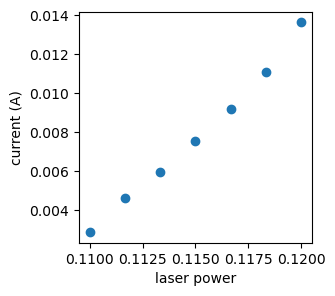

In [24]:
plt.close('all')
plt.figure(figsize = (3,3))
plt.scatter(laser_power, current)
plt.xlabel('laser power')
plt.ylabel('current (A)')
plt.show()

In [43]:
c.laser.set(power = 0.975)
c.laser.on()
time.sleep(1)
# c.keithley.read()
c.keithley.area = 25.81
c.keithley.voc()
time.sleep(2)
c.laser.off()

laser on
Voc: 667.37 mV


True

In [8]:
c.camera.connect()

True

## initial JV

In [71]:
laser_pw_to_set = np.linspace(0.2, 1, 5)*0.83

In [4]:
c.camera.disconnect()

True

laser on


<IPython.core.display.Javascript object>


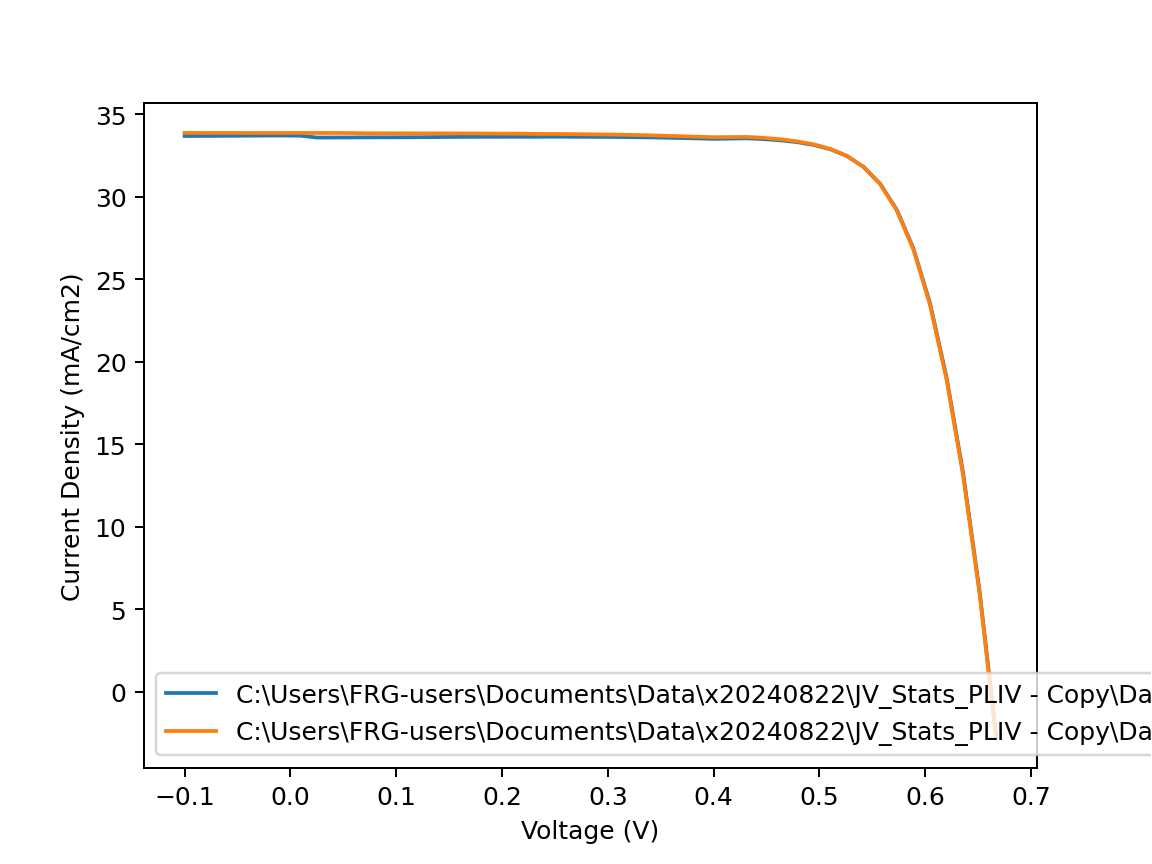

In [4]:
JVdatafolder = 'C:\\Users\\FRG-users\\Documents\\Data\\x20240822\\JV_Stats_PLIV - Copy\\Data'
# for i, pw in enumerate(laser_pw_to_set):
jv_name = os.path.join(JVdatafolder, 'SiTest_P4_S2')
c.laser.set(power = 0.83)
c.laser.on()
time.sleep(5)
c.keithley.area = 25.81
c.keithley.jv(jv_name, 'fwdrev', -0.1, 0.667, light = True)
c.laser.off()
time.sleep(10)

In [5]:
c.laser.off()

True

In [6]:
c.keithley.off()

True

In [10]:
c.camera.connect()

True

## take EL meas 

0.83
New sample: taking a 0 bias, 0 illumination baseline image.
0


0.83
laser on


<IPython.core.display.Javascript object>


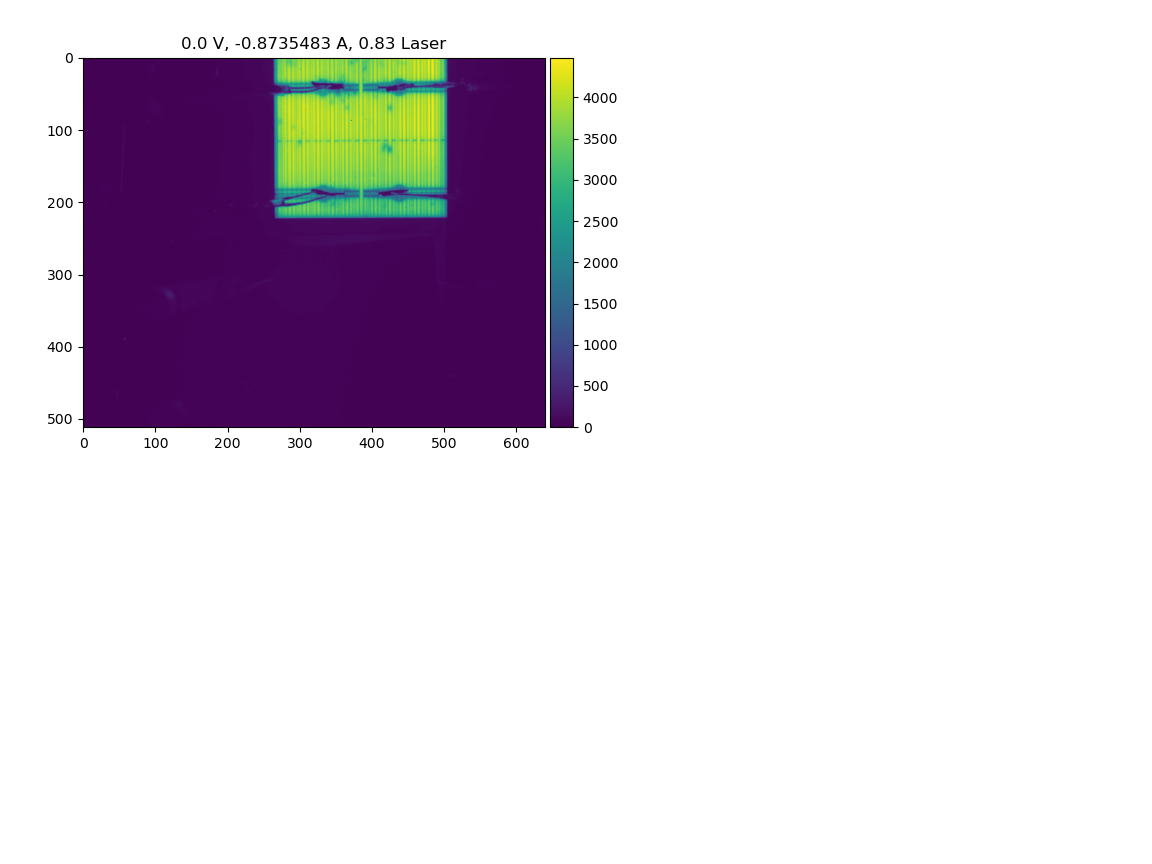

EL:   0%|          | 0/11 [00:00<?, ?it/s]

0.0


In [ ]:
c._sampleOneSun = 0.83
c.takeELMeas(0.005, 1.35, 17.03, 25.81*2, only_OneSun = True)
c.keithley.off()
c.save()

In [3]:
c.camera.disconnect()

True

In [6]:
c.camera.connect()

True

In [8]:
c.laser.off()

True

In [9]:
c.keithley.off()

True

## take pliv 

0.83
New sample: taking a 0 bias, 0 illumination baseline image.
0


0.83
laser on


<IPython.core.display.Javascript object>


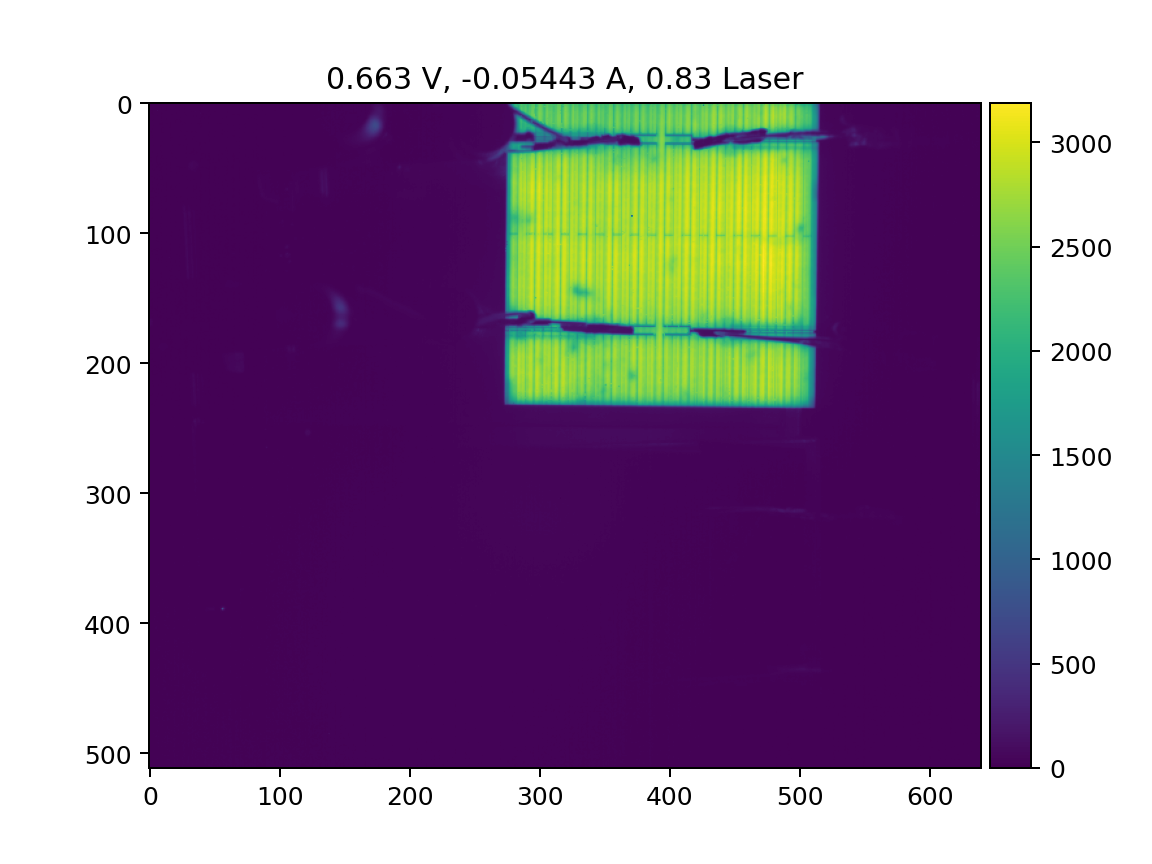

PLIV:   0%|          | 0/55 [00:00<?, ?it/s]

0.166
laser on



PLIV:   2%|▏         | 1/55 [00:07<06:47,  7.55s/it]             

0.166



PLIV:   4%|▎         | 2/55 [00:10<04:21,  4.94s/it]             

0.166



PLIV:   5%|▌         | 3/55 [00:13<03:32,  4.08s/it]             

0.166



PLIV:   7%|▋         | 4/55 [00:16<03:08,  3.70s/it]             

0.166



PLIV:   9%|▉         | 5/55 [00:19<02:54,  3.49s/it]             

0.166



PLIV:  11%|█         | 6/55 [00:22<02:43,  3.33s/it]             

0.166



PLIV:  13%|█▎        | 7/55 [00:26<02:36,  3.27s/it]             

0.166



PLIV:  15%|█▍        | 8/55 [00:29<02:30,  3.21s/it]             

0.166



PLIV:  16%|█▋        | 9/55 [00:32<02:24,  3.13s/it]             

0.166



PLIV:  18%|█▊        | 10/55 [00:35<02:18,  3.08s/it]            

0.166



PLIV:  20%|██        | 11/55 [00:38<02:15,  3.08s/it]            

0.332



PLIV:  22%|██▏       | 12/55 [00:41<02:12,  3.09s/it]            

0.332



PLIV:  24%|██▎       | 13/55 [00:44<02:10,  3.10s/it]            

0.332



PLIV:  25%|██▌       | 14/55 [00:47<02:06,  3.09s/it]            

0.332



PLIV:  27%|██▋       | 15/55 [00:50<02:02,  3.07s/it]            

0.332



PLIV:  29%|██▉       | 16/55 [00:53<01:59,  3.06s/it]            

0.332



PLIV:  31%|███       | 17/55 [00:56<01:56,  3.05s/it]            

0.332



PLIV:  33%|███▎      | 18/55 [00:59<01:51,  3.02s/it]            

0.332



PLIV:  35%|███▍      | 19/55 [01:02<01:48,  3.02s/it]            

0.332



PLIV:  36%|███▋      | 20/55 [01:05<01:47,  3.06s/it]            

0.332



PLIV:  38%|███▊      | 21/55 [01:08<01:43,  3.05s/it]            

0.332



PLIV:  40%|████      | 22/55 [01:11<01:40,  3.04s/it]            

0.49800000000000005



PLIV:  42%|████▏     | 23/55 [01:14<01:36,  3.02s/it]            

0.49800000000000005



PLIV:  44%|████▎     | 24/55 [01:17<01:34,  3.04s/it]            

0.49800000000000005



PLIV:  45%|████▌     | 25/55 [01:20<01:30,  3.03s/it]            

0.49800000000000005



PLIV:  47%|████▋     | 26/55 [01:23<01:27,  3.03s/it]            

0.49800000000000005



PLIV:  49%|████▉     | 27/55 [01:26<01:24,  3.02s/it]            

0.49800000000000005



PLIV:  51%|█████     | 28/55 [01:29<01:21,  3.03s/it]            

0.49800000000000005



PLIV:  53%|█████▎    | 29/55 [01:33<01:19,  3.07s/it]            

0.49800000000000005



PLIV:  55%|█████▍    | 30/55 [01:36<01:15,  3.03s/it]            

0.49800000000000005



PLIV:  56%|█████▋    | 31/55 [01:39<01:12,  3.04s/it]            

0.49800000000000005



PLIV:  58%|█████▊    | 32/55 [01:42<01:10,  3.05s/it]            

0.49800000000000005



PLIV:  60%|██████    | 33/55 [01:45<01:07,  3.06s/it]            

0.664



PLIV:  62%|██████▏   | 34/55 [01:48<01:04,  3.06s/it]            

0.664



PLIV:  64%|██████▎   | 35/55 [01:51<01:01,  3.05s/it]            

0.664



PLIV:  65%|██████▌   | 36/55 [01:54<00:57,  3.03s/it]            

0.664



PLIV:  67%|██████▋   | 37/55 [01:57<00:54,  3.04s/it]            

0.664



PLIV:  69%|██████▉   | 38/55 [02:00<00:51,  3.03s/it]            

0.664



PLIV:  71%|███████   | 39/55 [02:03<00:48,  3.04s/it]            

0.664



PLIV:  73%|███████▎  | 40/55 [02:06<00:46,  3.07s/it]            

0.664



PLIV:  75%|███████▍  | 41/55 [02:09<00:43,  3.08s/it]            

0.664



PLIV:  76%|███████▋  | 42/55 [02:12<00:39,  3.07s/it]            

0.664



PLIV:  78%|███████▊  | 43/55 [02:15<00:36,  3.08s/it]            

0.664



PLIV:  80%|████████  | 44/55 [02:18<00:33,  3.06s/it]            

0.83



PLIV:  82%|████████▏ | 45/55 [02:21<00:30,  3.05s/it]            

0.83



PLIV:  84%|████████▎ | 46/55 [02:24<00:27,  3.05s/it]            

0.83



PLIV:  85%|████████▌ | 47/55 [02:27<00:24,  3.04s/it]            

0.83



PLIV:  87%|████████▋ | 48/55 [02:30<00:21,  3.03s/it]            

0.83



PLIV:  89%|████████▉ | 49/55 [02:33<00:18,  3.04s/it]            

0.83



PLIV:  91%|█████████ | 50/55 [02:37<00:15,  3.05s/it]            

0.83



PLIV:  93%|█████████▎| 51/55 [02:40<00:12,  3.06s/it]            

0.83



PLIV:  95%|█████████▍| 52/55 [02:43<00:09,  3.05s/it]            

0.83



PLIV:  96%|█████████▋| 53/55 [02:46<00:06,  3.04s/it]            

0.83



PLIV:  98%|█████████▊| 54/55 [02:49<00:03,  3.02s/it]            

0.83



Acquiring Images:  95%|█████████▌| 19/20 [00:01<00:00, 13.37it/s]


laser off
Data saved to F:\x20240822\Data\20240822\frgPL_20240822_0008.h5
Note: sample name and one sun calibration results have been reset to None


'F:\\x20240822\\Data\\20240822\\frgPL_20240822_0008.h5'

In [3]:
c._sampleOneSun = 0.83
c.takePLIVMeas(0.5261, 0.663, 33.28, 25.81, only_OneSun = False, num_imgs = 10)
c.keithley.off()
c.save()

In [3]:
c.camera.disconnect()

True

In [15]:
c.laser.set(power = 0.83)
c.laser.on()
c.keithley.set_voltage(voltage = 0.66)
c.keithley.on()


laser on


True

In [6]:
c.laser.off()
c.keithley.off()

laser off


True

In [68]:
c.camera.connect()

True

In [67]:
c.camera.disconnect()

True

In [54]:
im_bkg, _, _  = c.camera.capture(frames = 20, imputeHotPixels = False)

# c.keithley.set_voltage(voltage = 1.35)
# c.keithley.on()
c.laser.set(power = 0.83)
c.laser.on()

# c.keithley.set_voltage(voltage = 0.668)
# c.keithley.on()
time.sleep(1)

im_, _, _  = c.camera.capture(frames = 20, imputeHotPixels = False)

c.laser.off()
# c.keithley.off()

# plt.close('all')
# plt.imshow(im_ - im_bkg)

laser on


True

<IPython.core.display.Javascript object>


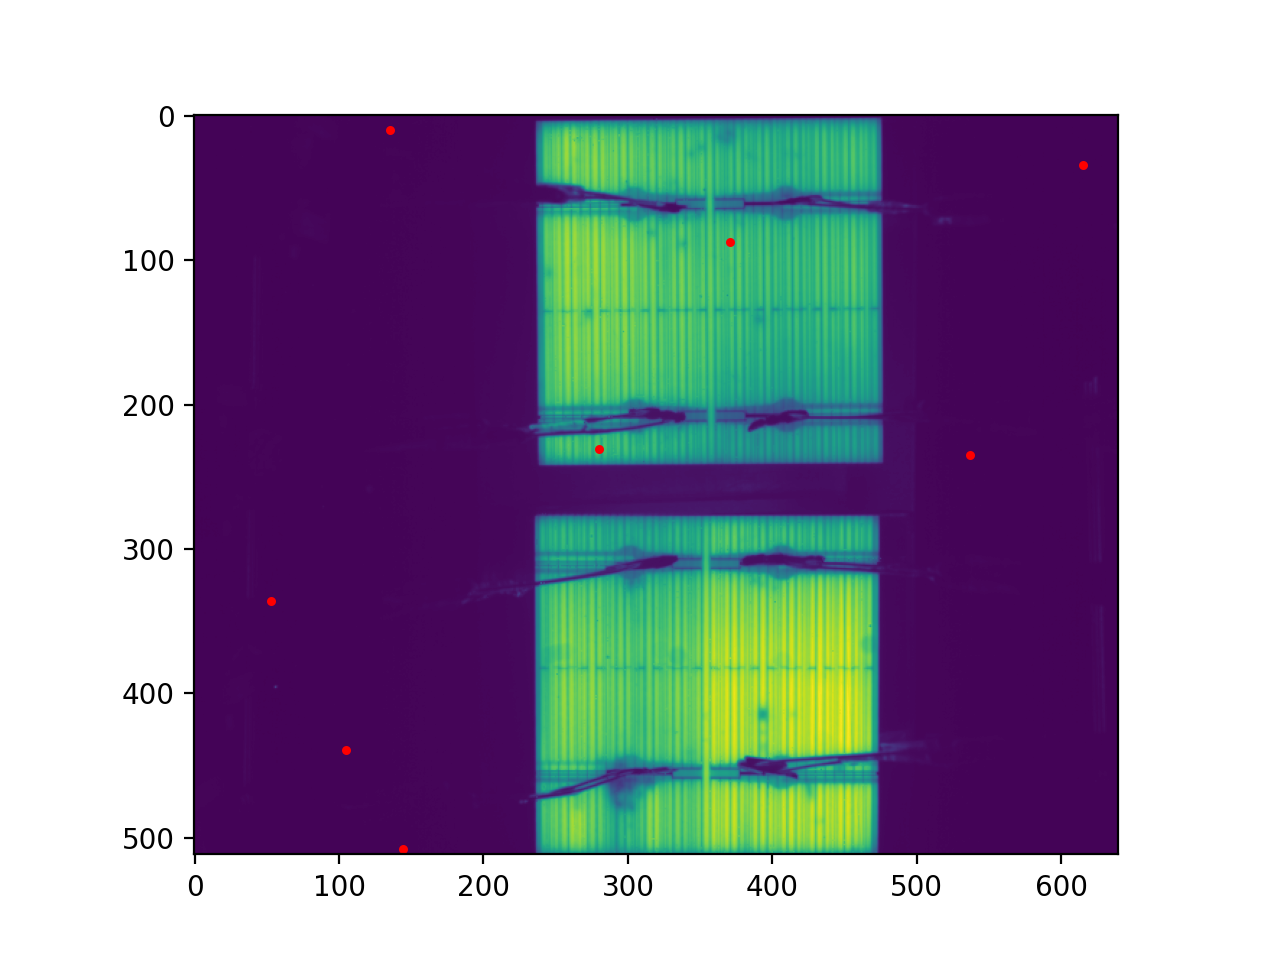

In [64]:
# c.keithley.off()

plt.close('all')
plt.imshow(im_ - im_bkg)

overexpose_pts = np.argwhere(im_ == 2**14-1)
plt.scatter(overexpose_pts[:, 1], overexpose_pts[:, 0], s = 5, color = 'r')